# Initialisation

In [25]:
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
import keras

from PIL import Image

from keras import layers
from keras.applications import mobilenet_v2
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from keras.models import Model, Sequential, load_model
from keras.layers import Lambda
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import seaborn as sns

import time
import pathlib

In [12]:
keras.version()

'3.11.2'

In [13]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
# Constants
DATA_SRC = 'garbage_classification/'
MODEL_PATH = "./garbage_classification.keras"
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

TRAIN_SIZE = 0.7
VAL_SIZE = 0.2
TEST_SIZE = 0.1

BATCH_SIZE = 32
EPOCHS = 20
SEED = 123

# Model Preparation

In [15]:
# Create the dataset (ds)
garbage_directory = pathlib.Path(DATA_SRC)
ds = image_dataset_from_directory(
    directory=garbage_directory,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    labels='inferred',
    label_mode='categorical',
    shuffle=True,
)

Found 15515 files belonging to 12 classes.


In [16]:
classes = ds.class_names
len_classes = len(classes)
print(f"Detected classes: {classes}\nClass size: {len_classes}")

Detected classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Class size: 12


In [17]:
# Apply the split to the dataset. 
total_batches = tf.data.experimental.cardinality(ds).numpy()
train_size = int(total_batches * TRAIN_SIZE)
val_size = int(total_batches * VAL_SIZE)
test_size = total_batches - train_size - val_size

if train_size + val_size + test_size != total_batches:
    print("ERROR: Invalid split sizes.")
    exit(1)

print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")
print(f"Total batches found: {total_batches}")

Train size: 339
Validation size: 97
Test size: 49
Total batches found: 485


In [18]:
# Split the dataset into train, validation and test. Each taking their respective sizes
train_ds = ds.take(train_size)
leftover_ds = ds.skip(train_size)
val_ds = leftover_ds.take(val_size)
test_ds = leftover_ds.skip(val_size)

print(f"Train size: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Validation size: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Test size: {tf.data.experimental.cardinality(test_ds).numpy()}")

Train size: 339
Validation size: 97
Test size: 49


In [19]:
# Alter the image in various ways so that the model is more robust
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
])

In [20]:
# Early stopping implemented here to ensure best efficiency in training. Ergo no overfitting occurs in the model
# After a certain point the model can lose acc and validation
early_stop = EarlyStopping(patience=3, verbose=1, monitor='val_categorical_accuracy',
                           mode='max', min_delta=0.001, restore_best_weights=True)

# Plateau will help to optimize the training  passively as the epochs go by.
plateau = ReduceLROnPlateau(
    monitor="val_categorical_accuracy",
    patience=3,
    factor=0.5,
    min_lr=1e-7,
    verbose=1
)

# This will actively monitor the learning process and save the best model.
checkpoint = ModelCheckpoint("garbage_classification_checkpoint.keras", monitor='val_categorical_accuracy', save_best_only=True,mode='max',verbose=1)

callbacks = [early_stop, plateau, checkpoint]

In [21]:
AUTOTUNE = tf.data.AUTOTUNE
def augment_ds(ds, augment=False):
    if augment:
        ds = ds.map(lambda a, b: (data_augmentation(a, training=True), b),
        num_parallel_calls=AUTOTUNE
        
        )
    ds = ds.cache()
    if augment:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [22]:
train_ds = augment_ds(train_ds, augment=True)
val_ds = augment_ds(val_ds, augment=False)
test_ds = augment_ds(test_ds, augment=False)

In [23]:
def preprocess_model_input(img):
    return mobilenet_v2.preprocess_input(img)

# Model Training

In [74]:
# Here we use transfer learning
mobile_model = mobilenet_v2.MobileNetV2(
    include_top=False,
    input_shape=IMG_SHAPE,
    weights='imagenet',
)
# Freeze the base model
mobile_model.trainable = False

model = Sequential()

model.add(keras.Input(shape=IMG_SHAPE))
# Preprocssessing to handle the image sizes
model.add(Lambda(preprocess_model_input))
model.add(mobile_model)
model.add(GlobalAveragePooling2D())

#1
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#2
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(len_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['categorical_accuracy']
)

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_4 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,621,900 (10.00 MB)

 Trainable params: 363,148 (1.39 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

In [75]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

model.save(MODEL_PATH)

Epoch 1/20


2025-12-10 04:21:35.157357: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3931: Filling up shuffle buffer (this may take a while): 254 of 1000
2025-12-10 04:21:53.096576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:3931: Filling up shuffle buffer (this may take a while): 312 of 1000
2025-12-10 04:22:00.957573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - categorical_accuracy: 0.6519 - loss: 1.1680
Epoch 1: val_categorical_accuracy improved from None to 0.90271, saving model to garbage_classification_checkpoint.keras
339/339 ━━━━━━━━━━━━━━━━━━━━ 94s 139ms/step - categorical_accuracy: 0.7585 - loss: 0.7889 - val_categorical_accuracy: 0.9027 - val_loss: 0.3010 - learning_rate: 0.0010
Epoch 2/20
338/339 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - categorical_accuracy: 0.8529 - loss: 0.4577
Epoch 2: val_categorical_accuracy improved from 0.90271 to 0.91527, saving model to garbage_classification_checkpoint.keras
339/339 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - categorical_accuracy: 0.8606 - loss: 0.4336 - val_categorical_accuracy: 0.9153 - val_loss: 0.2585 - learning_rate: 0.0010
Epoch 3/20
339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.8935 - loss: 0.3269
Epoch 3: val_categorical_accuracy improved from 0.91527 to 0.92010, saving model to garbage_classification_checkpoint.keras
339/339 ━

# Model Validation

In [ ]:
# If you would like to reload the model, run all the code in Initialisation and Model Preparation. 
# This will load the test generator and the model
try:
    keras.config.enable_unsafe_deserialization()
    model = load_model(MODEL_PATH, custom_objects={'preprocess_model_input': preprocess_model_input})
except Exception as e:
    print("ERROR: Model has not been loaded.", e)
    exit(1)

I0000 00:00:1765360022.806649    2358 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5130 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6


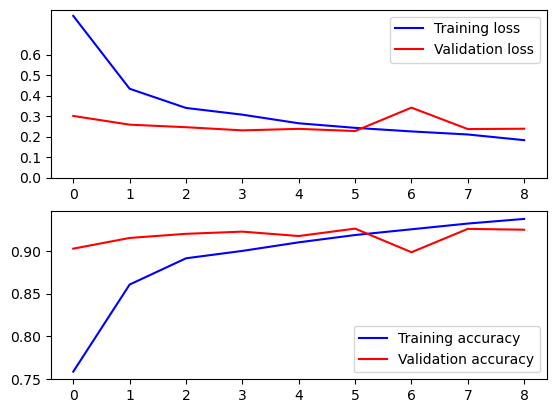

In [91]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.show()

In [24]:
loss, accuracy = model.evaluate(test_ds, verbose=1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy*100}%")

I0000 00:00:1765360090.872711    4570 service.cc:152] XLA service 0x7ff01c003df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765360090.872733    4570 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-12-10 13:48:11.008947: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765360091.345422    4570 cuda_dnn.cc:529] Loaded cuDNN version 91501
2025-12-10 13:48:12.094373: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1225_0', 464 bytes spill stores, 1372 bytes spill loads

2025-12-10 13:48:12.095126: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_d

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.9190 - loss: 0.2399

2025-12-10 13:48:25.346789: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1225', 232 bytes spill stores, 232 bytes spill loads

2025-12-10 13:48:25.366492: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1225_0', 404 bytes spill stores, 1288 bytes spill loads

2025-12-10 13:48:25.704459: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1225', 5524 bytes spill stores, 5564 bytes spill loads

2025-12-10 13:48:25.864699: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1225', 5352 bytes spill stores, 5352 bytes spill loads

2025-12-10 13:48:31.57920

49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 239ms/step - categorical_accuracy: 0.9322 - loss: 0.2019
Test Loss: 0.20194952189922333
Test Accuracy: 93.2181715965271%


In [103]:
y_pred_probs = model.predict(test_ds)

true_labels = []

for test_images, test_labels in test_ds:
    true_labels.extend(tf.argmax(test_labels, axis=1).numpy())

pred_labels = np.argmax(y_pred_probs, axis=1)

y_true = true_labels
y_pred = pred_labels


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [107]:
report = classification_report(y_true, y_pred, target_names=classes)
print(report)

              precision    recall  f1-score   support

     battery       0.91      0.97      0.94        94
  biological       0.95      0.97      0.96        92
 brown-glass       0.89      0.87      0.88        68
   cardboard       0.91      0.88      0.90       102
     clothes       0.97      0.99      0.98       537
 green-glass       0.91      0.86      0.88        56
       metal       0.87      0.77      0.81        86
       paper       0.92      0.86      0.89       105
     plastic       0.79      0.76      0.78        82
       shoes       0.97      0.96      0.96       214
       trash       1.00      0.84      0.91        51
 white-glass       0.75      0.91      0.82        76

    accuracy                           0.93      1563
   macro avg       0.90      0.89      0.89      1563
weighted avg       0.93      0.93      0.93      1563



<Axes: >

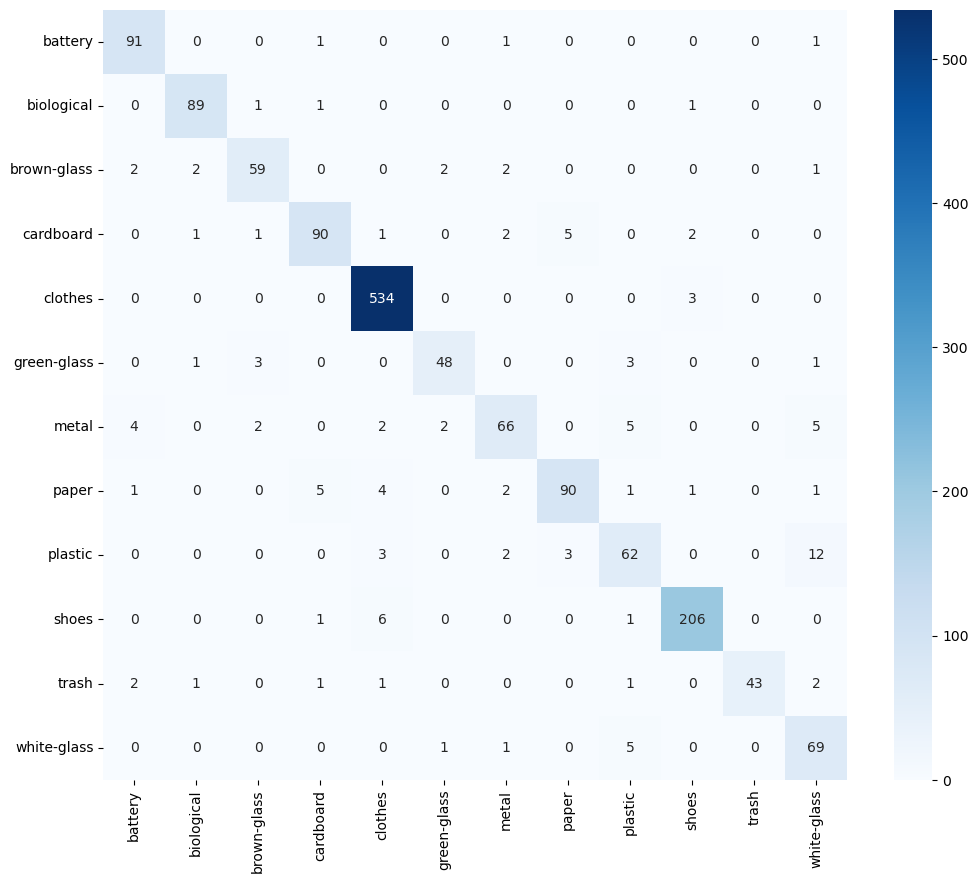

In [104]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=classes,
    yticklabels=classes
)

# Implementation with OpenCV

In [83]:
CAM_INDEX = 0
video_stream = cv2.VideoCapture(CAM_INDEX)
if not video_stream.isOpened():
    print("ERROR: Could not open camera.")
    exit(1)
print("Press 'ESC' to quit")

ERROR: Could not open camera.
Press 'ESC' to quit


[ WARN:0@1408.379] global cap_v4l.cpp:914 open VIDEOIO(V4L2:/dev/video0): can't open camera by index


In [ ]:
while True:
    # Capture frame-by-frame
    ret, frame = video_stream.read()

    if not ret:
        print("ERROR: Can't receive frame.")
        break
    
    stream_size = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
    stream_rgb = cv2.cvtColor(stream_size, cv2.COLOR_BGR2RGB)

    img_batch = np.expand_dims(stream_rgb, axis=0)
    
    models_prediction = model.predict(img_batch, verbose=0)
    
    models_prediction_class_idx = np.argmax(models_prediction[0])
    models_prediction_class_name = classes[models_prediction_class_idx]

    confidence = models_prediction[0][models_prediction_class_idx]

    if confidence > 0.75:
        color = (0, 255, 0)
    elif confidence > 0.5:
        color = (255, 255, 0)
    else:
        color = (0, 0, 255)
    
    cv2.putText(
        frame,
        f"{models_prediction_class_name} ({confidence*100:.2f}%)",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 0, 255),
        2
    )


    cv2.imshow("Garbage Classification", frame)

    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        print("Exiting the program...")
        break
    elif key == ord("s"):
        print("Saving the image...")
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        filename = f"image_{models_prediction_class_name}_{timestamp}.jpg"
        cv2.imwrite(filename, frame)
        

# When everything done, release the capture
video_stream.release()
cv2.destroyAllWindows()
print("Exiting the program...")

ERROR: Can't receive frame.
